In [1]:
import torch
from torch import nn
import torchvision
import copy



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 21 18:13:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |   1383MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.is_available()

True

# ** Importing Resnet Model


In [2]:
resnet18 = torchvision.models.resnet18()
resnet34= torchvision.models.resnet34()
resnet50= torchvision.models.resnet50()


In [3]:
resnet18_BYOL = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_BYOL = nn.Sequential(
    *list(resnet18_BYOL.children())[:-1],
)
ckpt = torch.load('/content/drive/MyDrive/Project/Models/BYOL_MODELS/BYOL(85,25EPOCHS,lr=0.06)model.pth')
backbone_BYOL.load_state_dict(ckpt['resnet18_parameters'])

<All keys matched successfully>

In [4]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
#Giving path 
images_path ="/content/drive/MyDrive/Project/Dataset/test_models"
anno_path = "/content/drive/MyDrive/Project/Dataset/test_models"

In [6]:
#Functions to read xml files

def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    #filename=[]
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = float(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = float(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = float(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = float(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
        #filename.append(root.find("./filename").text)
    return pd.DataFrame(anno_list)

In [ ]:
#df_train2=pd.read_csv('/content/drive/MyDrive/data/Training.csv')

In [ ]:
'''
# import required module
from pathlib import Path
img=[] 
 
# iterate over files in
# that directory
images = Path(images_path).glob('*.jpg')
for image in images:
    img.append(image) 
'''

"\n# import required module\nfrom pathlib import Path\nimg=[] \n \n# iterate over files in\n# that directory\nimages = Path(images_path).glob('*.jpg')\nfor image in images:\n    img.append(image) \n"

In [7]:
df_test = generate_train_df(anno_path)

In [ ]:
#from keras.preprocessing import image

In [ ]:
#img = image.load_img("/content/drive/MyDrive/data/train2/AdjustableClamp/014380.jpg", target_size=(224, 224))

# Convert the image to a numpy array
#x = image.img_to_array(img)

In [ ]:
#x.reshape()

In [ ]:
#del df_train['index']

In [ ]:
#df_train2.to_csv('/content/drive/MyDrive/training_demo/images/Training.csv')

In [8]:
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,SodaCan,173.8266,32.4639,219.6141,119.0416
1,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,SodaCan,65.5953,189.3861,116.7750,287.5889
2,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,SodaCan,220.8172,213.7666,268.6719,300.0000
3,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,SodaCan,102.2563,52.3472,186.8657,211.7222
4,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,SodaCan,127.6078,199.5083,173.4281,288.6139


In [9]:
#label encode target
class_dict = {'AdjustableClamp': 0,'AdjustableWrench': 1,'Battery': 2,'Bolt': 3,'BoltNutSet': 4,'BoltWasher': 5,'ClampPart': 6,'Cutter': 7,'FuelCap': 8,'Hammer': 9,'Hose': 10,'Label': 11,'LuggagePart': 12,'LuggageTag': 13,'MetalPart': 14,'MetalSheet': 15,'Nail': 16,'Nut': 17,'PaintChip': 18,'Pen': 19,'PlasticPart': 20,'Pliers': 21,'Rock': 22,'Screw': 23,'Screwdriver': 24,'SodaCan':25,'Tape': 26,'Washer': 27,'Wire': 28,'Wood': 29,'Wrench': 30}
df_test['class'] = df_test['class'].apply(lambda x:  class_dict[x])

In [10]:
print(df_test.shape)
df_test.head()

(8429, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,173.8266,32.4639,219.6141,119.0416
1,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,65.5953,189.3861,116.7750,287.5889
2,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,220.8172,213.7666,268.6719,300.0000
3,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,102.2563,52.3472,186.8657,211.7222
4,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,127.6078,199.5083,173.4281,288.6139


In [11]:
df_test[['xmin','ymin','xmax','ymax']] = df_test[['xmin','ymin','xmax','ymax']].astype(int)


In [12]:
#df_train[['filename']] = df_train[['filename']].astype(str)

In [13]:
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,173,32,219,119
1,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,65,189,116,287
2,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,220,213,268,300
3,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,102,52,186,211
4,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,127,199,173,288


## ** Data Pre-Processing Functions

In [14]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [15]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [16]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,173,32,219,119
1,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,65,189,116,287
2,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,220,213,268,300
3,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,102,52,186,211
4,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,127,199,173,288


In [17]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Project/Test')
for index, row in df_test.iterrows():
    #print(row['filename'])
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_test['new_path'] = new_paths
df_test['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [18]:
df_test.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,173,32,219,119,/content/drive/MyDrive/Project/Test/029672.jpg,"[32, 257, 118, 326]"
1,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,65,189,116,287,/content/drive/MyDrive/Project/Test/029607.jpg,"[189, 96, 286, 173]"
2,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,220,213,268,300,/content/drive/MyDrive/Project/Test/029712.jpg,"[213, 327, 299, 399]"
3,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,102,52,186,211,/content/drive/MyDrive/Project/Test/029755.jpg,"[52, 151, 210, 277]"
4,/content/drive/MyDrive/Project/Dataset/test_mo...,300,300,25,127,199,173,288,/content/drive/MyDrive/Project/Test/029727.jpg,"[199, 188, 287, 258]"


In [ ]:
#df_train.to_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")


In [ ]:
#df_train2=pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")

In [ ]:
#df_train2.drop(df_train2.columns[[0,1]], axis=1, inplace=True)
#pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")


In [19]:
im = cv2.imread(str(df_test.values[58][0]))
bb = create_bb_array(df_test.values[58])
print(im.shape)

(300, 300, 3)


In [20]:
Y = create_mask(bb, im)
mask_to_bb(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([ 85, 109, 203, 182], dtype=int32)

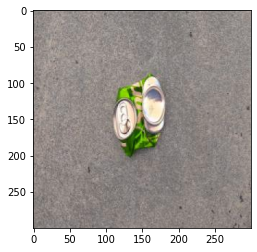

In [21]:
plt.imshow(im)

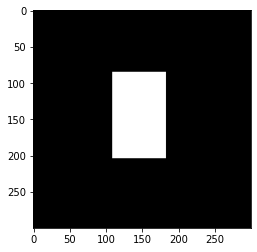

In [22]:
plt.imshow(Y, cmap='gray')

In [23]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [24]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [25]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [26]:
df_test.info

<bound method DataFrame.info of                                                filename width height  class  \
0     /content/drive/MyDrive/Project/Dataset/test_mo...   300    300     25   
1     /content/drive/MyDrive/Project/Dataset/test_mo...   300    300     25   
2     /content/drive/MyDrive/Project/Dataset/test_mo...   300    300     25   
3     /content/drive/MyDrive/Project/Dataset/test_mo...   300    300     25   
4     /content/drive/MyDrive/Project/Dataset/test_mo...   300    300     25   
...                                                 ...   ...    ...    ...   
8424  /content/drive/MyDrive/Project/Dataset/test_mo...   300    300      5   
8425  /content/drive/MyDrive/Project/Dataset/test_mo...   300    300      5   
8426  /content/drive/MyDrive/Project/Dataset/test_mo...   300    300      5   
8427  /content/drive/MyDrive/Project/Dataset/test_mo...   300    300      5   
8428  /content/drive/MyDrive/Project/Dataset/test_mo...   300    300      5   

      xmin  ymin  x

In [ ]:
df_test.values[0][8]

'/content/drive/MyDrive/Project/Test/029672.jpg'

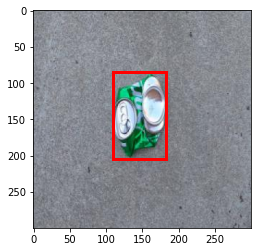

In [27]:
#original
im = cv2.imread(str(df_test.values[58][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, [df_test.values[58][5],df_test.values[58][4],df_test.values[58][7],df_test.values[58][6]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


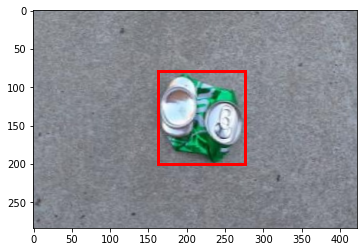

In [28]:
# after transformation
im, bb = transformsXY(str(df_test.values[58][8]),df_test.values[58][9],True)
show_corner_bb(im, bb)

In [ ]:
bb

In [29]:
df_train = df_test.reset_index()

## ** SPLIT DATA

In [30]:
X = df_test[['new_path', 'new_bb']]
Y = df_test['class']

In [31]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [32]:
class FOD(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [33]:

valid_ds = FOD(X['new_path'],X['new_bb'],Y)

In [34]:

valid_dl = DataLoader(valid_ds, batch_size=32)

#Defining Model

In [35]:
class BB_model(nn.Module):
    def __init__(self,backbone):
        super(BB_model, self).__init__()
        self.backbone=backbone
        layers = list(backbone.children())[:-1]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 31))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [36]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## ** Loading Trained model for Test

In [38]:
model1 = torch.load("/content/drive/MyDrive/Project/Trained_Models/BYOL_Resnet18.pth")
model2 = torch.load("/content/drive/MyDrive/Project/Trained_Models/BYOL_Resnet18.pth")
model3 = torch.load("/content/drive/MyDrive/Project/Trained_Models/Resnet34.pth")
model4=torch.load("/content/drive/MyDrive/Models_8k/BYOL_resnet18.pth")

In [ ]:
''' !pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   '''

## ** Testing 

'032431.jpg'

In [39]:
y=list(Y)

In [40]:
X.head()

,new_path,new_bb
0,/content/drive/MyDrive/Project/Test/029672.jpg,"[32, 257, 118, 326]"
1,/content/drive/MyDrive/Project/Test/029607.jpg,"[189, 96, 286, 173]"
2,/content/drive/MyDrive/Project/Test/029712.jpg,"[213, 327, 299, 399]"
3,/content/drive/MyDrive/Project/Test/029755.jpg,"[52, 151, 210, 277]"
4,/content/drive/MyDrive/Project/Test/029727.jpg,"[199, 188, 287, 258]"


In [44]:
New_Testing_Path=[]

In [45]:
for i in range(len(X)):
  im = read_image(X['new_path'][i])
  im = cv2.resize(im, (int(1.49*300), 300))
  cv2.imwrite('/content/drive/MyDrive/Project/Dataset/Test/'+X['new_path'][i][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))
  New_Testing_Path.append('/content/drive/MyDrive/Project/Dataset/Test/'+X['new_path'][i][-10:])

  '''test_ds = FOD(pd.DataFrame([{'path':X['new_path'][i]}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
  x, y_class, y_bb = test_ds[0]'''

In [ ]:
# resizing test image and passing it to new test folder
''' im = read_image(X['new_path'][1])
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('//content/drive/MyDrive/Project/Dataset/Test_New_Path'+X['new_path'][1][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))'''

True

In [46]:
X['new_path_test']= New_Testing_Path

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
len(X['new_path_test'])

8429

In [ ]:
#del Test_data

NameError: ignored

In [48]:
# Reading Whole X_Val

Test_data=FOD(X['new_path_test'],pd.DataFrame(np.zeros((8429, 4))),pd.DataFrame(np.zeros((8429, 1))))
d = pd.DataFrame(np.zeros((8429, 4)))
len(Test_data)

8429

In [ ]:
'''test_ds = FOD(pd.DataFrame([{'path':X['new_path'][1]}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [49]:
y_predict=[]

In [50]:
for i in range (len(Test_data)):
  x, y_class, y_bb = Test_data[i]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model4(xx.cuda())
  oclass=torch.max(out_class, 1).indices.detach().cpu().numpy()
  oclass=oclass.astype(int)
  y_predict.append(oclass[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [51]:
x, y_class, y_bb = Test_data[8428]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [52]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [53]:

# prediction
out_class, out_bb = model4(xx.cuda())
#print("I am out",out_class)
# predicted class
torch.max(out_class, 1).indices


tensor([5], device='cuda:0')

In [54]:
oclass=torch.max(out_class, 1).indices.detach().cpu().numpy()
oclass=oclass.astype(int)

In [56]:
bb_predict=[]

In [60]:
for i in range (len(Test_data)):
  x, y_class, y_bb = Test_data[i]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model4(xx.cuda())
  bb_whole=out_bb.detach().cpu().numpy()
  bb_whole = bb_whole.astype(int)
  bb_predict.append(bb_whole[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [61]:
bb_predict[0]

array([ 16, 219, 122, 313])

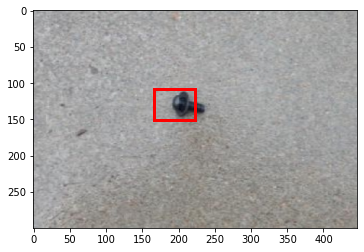

In [89]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])


In [ ]:
bb_hat[0]

array([190, 123, 303, 191])

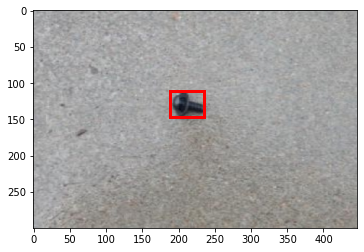

In [62]:
# Drawing bounding box from actual
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, X['new_bb'][8428])

In [63]:
# Creating Different Colours
def create_corner_rect_v2(bb, color):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# Ground vs Predicted Bounding Boxs
def plot_two_rectangle(im,bb1,bb2):
  plt.imshow(im)
  plt.gca().add_patch(create_corner_rect_v2(bb1,color='red'))
  plt.gca().add_patch(create_corner_rect_v2(bb2,color='green'))

8429

## ** Defining Testing Metrics

In [64]:
# Defining IOU
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou

In [65]:
ground_truth_bbox = np.array([X['new_bb'][0][0],X['new_bb'][0][1],X['new_bb'][0][2],X['new_bb'][0][3]], dtype=np.float32)

prediction_bbox = np.array([bb_whole[0][0],bb_whole[0][1],bb_whole[0][2],bb_hat[0][3]], dtype=np.float32)

In [67]:
get_iou(ground_truth_bbox, prediction_bbox)

0.0

In [66]:
IoU=[]

In [73]:
for i in range(len(X)):
  ground_truth_bbox = np.array([X['new_bb'][i][0],X['new_bb'][i][1],X['new_bb'][i][2],X['new_bb'][i][3]], dtype=np.float32)
  prediction_bbox = np.array([bb_predict[i][0],bb_predict[i][1],bb_predict[i][2],bb_predict[i][3]], dtype=np.float32)
  IoU.append(get_iou(ground_truth_bbox, prediction_bbox))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [72]:
IoU[8428]

0.4445927903871829

TypeError: ignored

In [86]:
#Defining IoU for everyone
sum=0.0
for i in range(len(IoU)):
  sum=sum+IoU[i]



1.0369377740445498

In [84]:
sum\\

nan

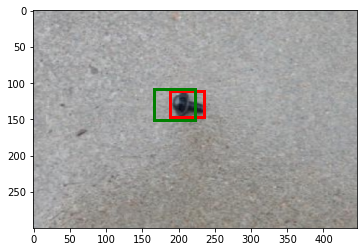

In [74]:
# Import dependencies.
plot_two_rectangle(im,ground_truth_bbox,prediction_bbox)

In [ ]:
#Defining Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

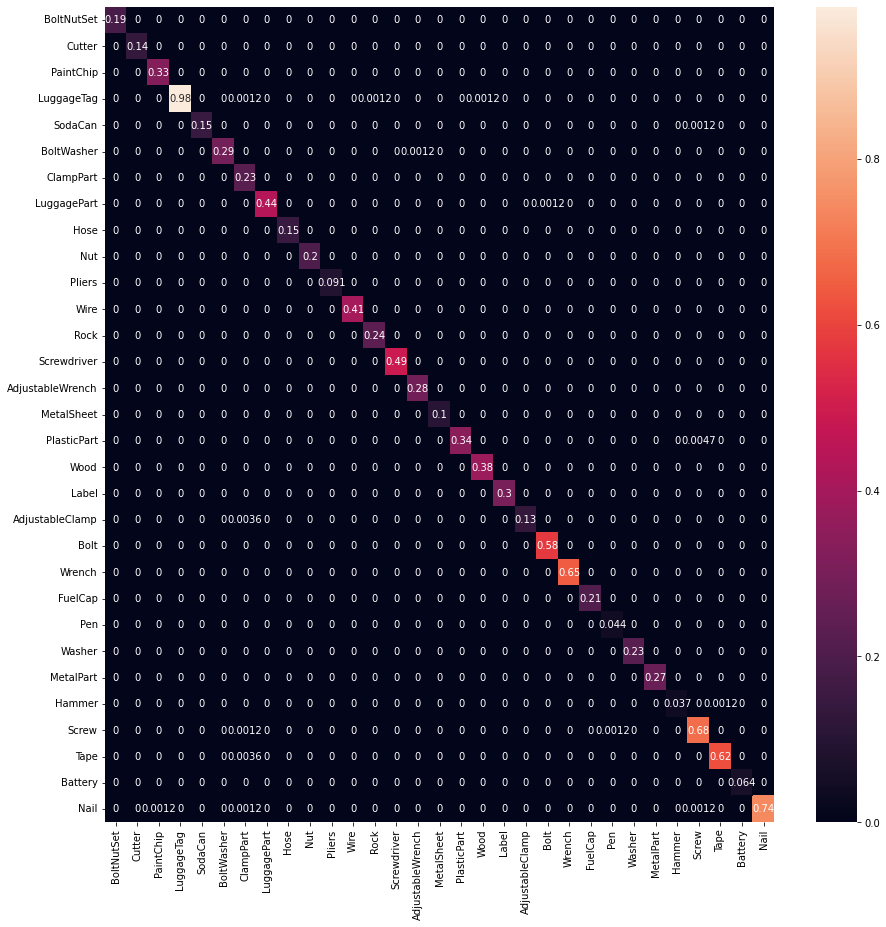

In [85]:

y_true = list(Y)

from sklearn import metrics



# constant for classes
classes = ('BoltNutSet', 'Cutter', 'PaintChip', 'LuggageTag', 'SodaCan', 'BoltWasher', 'ClampPart', 'LuggagePart', 'Hose', 'Nut', 'Pliers', 'Wire', 'Rock', 'Screwdriver', 'AdjustableWrench', 'MetalSheet', 'PlasticPart', 'Wood', 'Label', 'AdjustableClamp', 'Bolt', 'Wrench', 'FuelCap', 'Pen', 'Washer', 'MetalPart', 'Hammer', 'Screw', 'Tape', 'Battery', 'Nail')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_predict)
#print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('BYOL_modeloutput 8k.png')

In [ ]:
y_true = pd.Series(y_true, name='Actual')
y_predict = pd.Series(y_predict, name='Predicted')



In [77]:
#print accuracy of model
print(metrics.accuracy_score(y_true, y_predict))



#print precision value of model
print(metrics.precision_score(y_true, y_predict,average='weighted'))



#print recall value of model
print(metrics.recall_score(y_true, y_predict,average='macro'))

0.9973899632222091
0.9974474719555741
0.9966732575153368


## ** Saving Model

In [ ]:
#torch.save(model,"/content/drive/MyDrive/Models/Resnet18.h5")